In [22]:
!pip install kagglehub

In [23]:
!pip install xgboost

In [24]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("bhanupratapbiswas/loan-approval-prediction-case-study")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\rakes\.cache\kagglehub\datasets\bhanupratapbiswas\loan-approval-prediction-case-study\versions\1


In [37]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

# Load the dataset
df = pd.read_csv(r"C:\Users\rakes\Downloads\archive (9)\loan_prediction2.csv")  # Replace with your dataset path

# Display dataset info
print(df.head())
print(df.info())



   S.NO   Loan_ID Gender Married Dependents     Education Self_Employed  \
0     0  LP001002   Male      No          0      Graduate            No   
1     1  LP001003   Male     Yes          1      Graduate            No   
2     2  LP001005   Male     Yes          0      Graduate           Yes   
3     3  LP001006   Male     Yes          0  Not Graduate            No   
4     4  LP001008   Male      No          0      Graduate            No   

   ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
0             5849                0.0         NaN             360.0   
1             4583             1508.0       128.0             360.0   
2             3000                0.0        66.0             360.0   
3             2583             2358.0       120.0             360.0   
4             6000                0.0       141.0             360.0   

   Credit_History Property_Area Loan_Status  
0             1.0         Urban           Y  
1             1.0         Rura

In [38]:
# Step 1: Handle Missing Values
imputer = SimpleImputer(strategy='most_frequent')  # Impute missing categorical values with mode
df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)



In [39]:
# Step 2: Encode Categorical Variables
label_encoders = {}
for col in df_imputed.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df_imputed[col] = le.fit_transform(df_imputed[col])
    label_encoders[col] = le  # Store encoders for inverse transform if needed


In [40]:
# Step 3: Define Features and Target
# Drop unnecessary columns
df_imputed = df_imputed.drop(columns=['S.NO','Loan_ID', 'Gender'])
X = df_imputed.drop(columns=['Loan_Status'])  # Assuming 'Loan_Status' is the target variable
y = df_imputed['Loan_Status']
df_imputed



,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,0,0,0,0,376,0,73,8,1,2,1
1,1,1,0,0,306,60,81,8,1,0,0
2,1,0,0,1,139,0,26,8,1,2,1
3,1,0,1,0,90,160,73,8,1,2,1
4,0,0,0,0,381,0,94,8,1,2,1
...,...,...,...,...,...,...,...,...,...,...,...
609,0,0,0,0,125,0,29,8,1,0,1
610,1,3,0,0,275,0,7,5,1,0,1
611,1,1,0,0,431,3,162,8,1,2,1
612,1,2,0,0,422,0,132,8,1,2,1


In [41]:
# Step 4: Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 5: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# Step 6: Model Selection & Training
models = {
    "Random Forest": RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42),
    "XGBoost": XGBClassifier(n_estimators=200, learning_rate=0.05, max_depth=6, random_state=42)
}

best_model = None
best_score = 0

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"{name} Accuracy: {acc:.4f}")
    
    if acc > best_score:
        best_score = acc
        best_model = model

print("\nBest Model:", best_model)


Random Forest Accuracy: 0.8455
XGBoost Accuracy: 0.8049

Best Model: RandomForestClassifier(max_depth=10, n_estimators=200, random_state=42)


In [42]:
# Step 7: Hyperparameter Tuning (For Best Model)
if isinstance(best_model, RandomForestClassifier):
    param_grid = {
        "n_estimators": [100, 200, 300],
        "max_depth": [4, 6, 8],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4]
    }
elif isinstance(best_model, XGBClassifier):
    param_grid = {
        "n_estimators": [100, 200, 300],
        "max_depth": [4, 6, 8],
        "learning_rate": [0.01, 0.05, 0.1],
        "subsample": [0.8, 1.0]
    }

# Perform GridSearchCV
grid_search = GridSearchCV(best_model, param_grid, scoring='accuracy', cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best model
best_model = grid_search.best_estimator_
print("\nBest Parameters:", grid_search.best_params_)



Best Parameters: {'max_depth': 6, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


In [43]:
# Step 8: Final Model Evaluation
y_pred_final = best_model.predict(X_test)
print("\nClassification Report:\n", classification_report(y_test, y_pred_final))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_final))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_final))




Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.61      0.73        38
           1       0.85      0.98      0.91        85

    accuracy                           0.86       123
   macro avg       0.88      0.79      0.82       123
weighted avg       0.87      0.86      0.85       123

Confusion Matrix:
 [[23 15]
 [ 2 83]]
ROC AUC Score: 0.7908668730650155


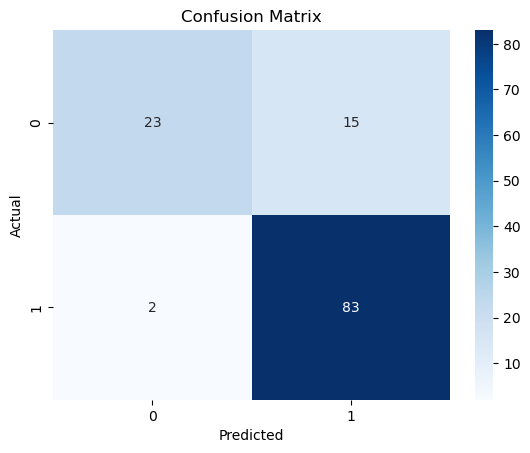

In [44]:
# Step 9: Visualization
sns.heatmap(confusion_matrix(y_test, y_pred_final), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [52]:
import numpy as np

# Function to take user input and predict loan approval
def predict_loan_status(input_data):
    """
    Predicts loan approval based on user input.
    :param input_data: List of feature values in correct order
    :return: 'Approved' or 'Rejected'
    """
    # Convert input data to NumPy array
    input_array = np.array(input_data).reshape(1, -1)
    
    # Apply the same feature scaling used during training
    input_scaled = scaler.transform(input_array)
    
    # Make prediction
    prediction = best_model.predict(input_scaled)
    
    # Map result to readable output
    result = "Approved" if prediction[0] == 1 else "Rejected"
    return result

# Example input data (Modify based on your dataset)
# Format: [Feature1, Feature2, ..., FeatureN] in correct order
example_input = [0,0,0,0,0,0,0,0,0,0]  # Modify as per dataset

# Get prediction
result = predict_loan_status(example_input)
print("Loan Status Prediction:", result)


Loan Status Prediction: Rejected


C:\Users\rakes\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
